# Data Import and Cleaning

## Full Run (q64)

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import math


In [2]:
# Color style similar to ppt color scheme
plt.style.use('seaborn-colorblind')

#Latex Default Font
plt.rc('font', family='serif') 
plt.rc('font', serif='Latin Modern Roman')
matplotlib.rcParams.update({'font.size': 16})

In [3]:
res = pd.read_csv("raw/q64.csv", header=0, comment='#')

# Times from cycles to micro seconds
res['RunTime'] = res['RunTime'] / 3.2E9
res['t_bookkeeping'] = res['t_bookkeeping'] / 3.2E9
res['t_rmem_write'] = res['t_rmem_write'] / 3.2E9
res['t_rmem_read'] = res['t_rmem_read'] / 3.2E9
res['t_fault'] = res['t_fault'] / 3.2E9
res['t_kpfad'] = res['t_kpfad'] / 3.2E9

# Size from absolute to "%local"
res['MemSize'] = (res['MemSize'] / 64000000)*100
res


,Config,Benchmark,MemSize,RunTime,t_bookkeeping,t_rmem_write,t_rmem_read,n_fault,t_fault,n_swapfault,n_pfa_fault,n_early_newq,n_evicted,n_fetched,t_kpfad,n_kpfad
0,pfa64_real,Qsort,100.0,1.966676,5.062500e-08,0.000000,0.0,15646,0.082899,0,0,0,0,0,0.0,0
1,pfa64_real,Qsort,75.0,2.632777,3.393620e-01,0.061589,0.0,67059,0.463003,0,485,4808,34371,30999,0.0,0
2,pfa64_real,Qsort,50.0,3.001175,5.139325e-01,0.095467,0.0,63275,0.679667,0,750,10668,55437,47979,0.0,0
3,pfa64_real,Qsort,25.0,3.616395,8.188448e-01,0.187548,0.0,71021,1.042739,0,1190,23371,87785,76202,0.0,0
4,pfa64_real,Genome,100.0,1.280805,6.843750e-07,0.000000,0.0,20971,0.157918,0,0,8,0,0,0.0,0
5,pfa64_real,Genome,75.0,1.149646,6.775204e-02,0.011842,0.0,48674,0.172773,0,83,57,8481,5281,0.0,0
6,pfa64_real,Genome,50.0,2.096780,4.973038e-01,0.072377,0.0,302931,0.773857,0,628,5933,47511,40182,0.0,0
7,pfa64_real,Genome,25.0,13.774580,6.877112e+00,1.604336,0.0,917568,7.628247,0,9836,42572,640934,629528,0.0,0
8,sw_real,Qsort,100.0,1.956014,0.000000e+00,0.000000,0.0,15646,0.069127,0,0,0,0,0,0.0,0
9,sw_real,Qsort,75.0,3.386101,8.125450e-01,0.000000,0.0,102578,1.019956,30919,0,0,34296,0,0.0,0


In [4]:
# Split by benchmark
gen_pfa_res    = res.loc[res['Config'] == "pfa64_real"   ].loc[res['Benchmark'] == "Genome"].set_index('MemSize')
gen_sw_res = res.loc[res['Config'] == "sw_real"].loc[res['Benchmark'] == "Genome"].set_index('MemSize')

qsort_pfa_res = res.loc[res['Config'] == "pfa64_real"].loc[res['Benchmark'] == "Qsort"].set_index('MemSize')
qsort_sw_res = res.loc[res['Config'] == "sw_real"].loc[res['Benchmark'] == "Qsort"].set_index('MemSize')

In [5]:
# Normalize to the 100% case (Runtime now a "Slowdown")
def NormalizeRuntime(r):
    r['Slowdown'] = r['RunTime'] / r['RunTime'].loc[100]
    return r.drop(100)

gen_pfa_res =      NormalizeRuntime(gen_pfa_res)
gen_sw_res =   NormalizeRuntime(gen_sw_res)
qsort_pfa_res =    NormalizeRuntime(qsort_pfa_res)
qsort_sw_res = NormalizeRuntime(qsort_sw_res)

## Micro-Benchmarks and Measurements

In [6]:
micro = pd.read_csv("raw/micro.csv", header=0, comment='#')
# Convert cycles to seconds
micro['PFA'] = micro['PFA'] / 3.2
micro['SW'] = micro['SW'] / 3.2
micro_mean = micro.groupby('measurement').mean()
micro_std = micro.groupby('measurement').std()

### Mean:

In [7]:
t_pfa = (micro_mean['PFA']['t_miss'] - 4088.4375) + 1129
t_sw = (micro_mean['SW']['t_miss'] - 4088.4375) + 1129
print((t_pfa - 1129) / t_pfa)
print((t_sw - 1129) / t_sw)
micro_mean

0.2354347872092777
0.8345484520974538


,PFA,SW
measurement,,
t_fetch,NaN,9620.028409
t_miss,4436.093750,9783.187500
t_read_real,NaN,NaN
t_read_switch_memblade_measured,NaN,4814.573864
t_read_switch_memblade_theory,4088.437500,4088.437500
t_trap,113.409091,113.409091


### Standard Deviation:

In [8]:
micro_std

,PFA,SW
measurement,,
t_fetch,NaN,128.431984
t_miss,8.766416,187.107448
t_read_real,NaN,NaN
t_read_switch_memblade_measured,NaN,49.102347
t_read_switch_memblade_theory,NaN,NaN
t_trap,16.274894,16.274894


# Facts and Figures

## Fault Timing Breakdown

2.194146032193301


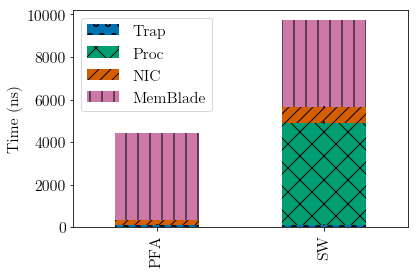

In [9]:
def breakdown_fault(df):
    tmp = df.transpose().fillna(0)
    ft = pd.DataFrame(index=tmp.index.copy())
    ft['Trap'] = tmp['t_trap']
    ft['Proc'] = tmp['t_fetch'] - tmp['t_read_switch_memblade_measured']
    # This is measured directly in VCS
    ft['Proc']['PFA'] = 1 / 3.2
    ft['NIC'] = tmp['t_read_switch_memblade_measured'] - tmp['t_read_switch_memblade_theory']
    ft['NIC']['PFA'] = tmp['t_miss']['PFA'] - ft['Trap']['PFA'] - ft['Proc']['PFA'] - tmp['t_read_switch_memblade_theory']['PFA']
    ft['MemBlade'] = tmp['t_read_switch_memblade_theory']
    #This is an optimistic memory blade (~1us)
    #ft['MemBlade'] = 1129
    return ft
    

pfa_fetchtime_mean = breakdown_fault(micro_mean)
pfa_fetchtime_std  = breakdown_fault(micro_std)
pfa_fetchtime_std['MemBlade'] = 0

print(pfa_fetchtime_mean.sum(axis=1)['SW'] / pfa_fetchtime_mean.sum(axis=1)['PFA'])
ax = pfa_fetchtime_mean.plot(kind='bar', stacked=True, yerr=pfa_fetchtime_std, legend=False)
#ax = pfa_fetchtime_mean.plot(kind='bar', stacked=True, legend=False)
hatches = ['o', 'o', 'x', 'x', '//', '//','|','|']
for i,bar in enumerate(ax.patches):
    bar.set_hatch(hatches[i])

ax.legend()
ax.set_ylabel('Time (ns)')
plt.savefig('figs/fetch_breakdown.png', dpi=300, bbox_inches='tight')
plt.show()

## Page Faults

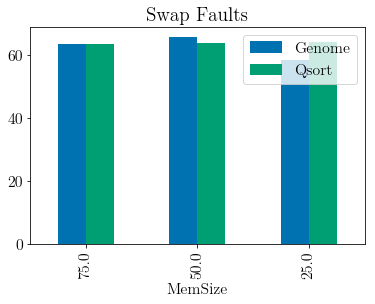

In [10]:
swap_pf = pd.concat([(gen_sw_res['n_swapfault'] / gen_pfa_res['n_pfa_fault']).rename("Genome"),
                      (qsort_sw_res['n_swapfault'] / qsort_pfa_res['n_pfa_fault']).rename("Qsort")],
                     axis=1)

swap_pf.plot(kind='bar', title='Swap Faults')
plt.show()

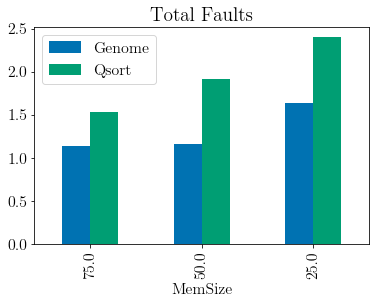

In [11]:
total_pf = pd.concat([(gen_sw_res['n_fault'] / gen_pfa_res['n_fault']).rename("Genome"),
                      (qsort_sw_res['n_fault'] / qsort_pfa_res['n_fault']).rename("Qsort")],
                     axis=1)

total_pf.plot(kind='bar', title='Total Faults')
plt.show()

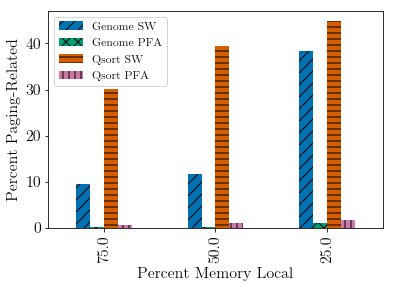

In [12]:
swap_fault_frac = pd.concat([
    (gen_sw_res['n_swapfault'] / gen_sw_res['n_fault']).rename("Genome SW"),
    (gen_pfa_res['n_pfa_fault'] / gen_pfa_res['n_fault']).rename("Genome PFA"),
    (qsort_sw_res['n_swapfault'] / qsort_sw_res['n_fault']).rename("Qsort SW"),
    (qsort_pfa_res['n_pfa_fault'] / qsort_pfa_res['n_fault']).rename("Qsort PFA")],
    axis=1)

ax = (swap_fault_frac * 100).plot(kind='bar', legend=False)
hatches = ['//', '//', '//', 2*'x', 2*'x', 2*'x', '--', '--', '--','||','||','||']
for i,bar in enumerate(ax.patches):
    bar.set_hatch(hatches[i])

ax.legend(fontsize=12)
ax.set_ylabel('Percent Paging-Related')
ax.set_xlabel('Percent Memory Local')
plt.savefig('figs/swapfault.png', dpi=300, bbox_inches='tight')
plt.show()

### Effectiveness of fetched bit (early newq)

In [13]:
early_newq_frac = pd.concat([
    (gen_pfa_res['n_pfa_fault'] / gen_pfa_res['n_fault']).rename("Genome PFA"),
    (qsort_pfa_res['n_pfa_fault'] / qsort_pfa_res['n_fault']).rename("Qsort PFA")],
    axis=1)

early_newq_frac

,Genome PFA,Qsort PFA
MemSize,,
75.0,0.001705,0.007232
50.0,0.002073,0.011853
25.0,0.010720,0.016756


## Bookkeeping Time

### PFA Savings in bookkeeping time

In [14]:
# Bookkeeping Time
gen_pfa_bk = gen_pfa_res['t_bookkeeping'].astype('float')
gen_sw_bk = gen_sw_res['t_bookkeeping'].astype('float')

qsort_pfa_bk = qsort_pfa_res['t_bookkeeping'].astype('float')
qsort_sw_bk = qsort_sw_res['t_bookkeeping'].astype('float')

print("Average Slowdown in Bookkeeping time (pfa / sw)")
print("QSort: " + str(np.mean(qsort_sw_bk.values / qsort_pfa_bk.values)))
print("Genome: " + str(np.mean(gen_sw_bk.values / gen_pfa_bk.values)))

# Ratio of PFA runtime vs SW
print("\Bookkeeping slowdown relative to PFA")
relative_bk = pd.concat([(gen_sw_res['t_bookkeeping'] / gen_pfa_res['t_bookkeeping']).rename("gen"),
                            (qsort_sw_res['t_bookkeeping'] / qsort_pfa_res['t_bookkeeping']).rename("qsort")], axis=1)
print(relative_bk)


Average Slowdown in Bookkeeping time (pfa / sw)
QSort: 2.4768285202509412
Genome: 2.1548660638811703
\Bookkeeping slowdown relative to PFA
              gen     qsort
MemSize                    
75.0     2.320476  2.394331
50.0     2.257922  2.524236
25.0     1.886200  2.511918


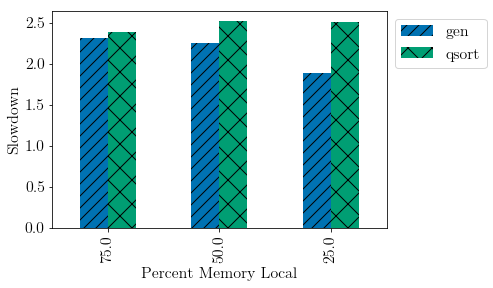

In [15]:
ax = relative_bk.plot(kind="bar", legend=False)

hatches = ['//', '//', '//', 'x', 'x', 'x']
for i,bar in enumerate(ax.patches):
    bar.set_hatch(hatches[i])
    
ax.legend(bbox_to_anchor=(1, 1), loc=2)
ax.set_ylabel('Slowdown')
ax.set_xlabel('Percent Memory Local')
plt.show()

### Time Spent In Bookkeeping

In [16]:
def NormalizeBK(r):
    r['bk_prop'] = r['t_bookkeeping'] / r['RunTime']
    return r

gen_pfa_res =      NormalizeBK(gen_pfa_res)
gen_sw_res =   NormalizeBK(gen_sw_res)
qsort_pfa_res =    NormalizeBK(qsort_pfa_res)
qsort_sw_res = NormalizeBK(qsort_sw_res)

gen_bk_prop = pd.concat([gen_pfa_res['bk_prop'].rename('Gen PFA'), gen_sw_res['bk_prop'].rename("Gen SW")], axis=1)
qsort_bk_prop = pd.concat([qsort_pfa_res['bk_prop'].rename('Qsort PFA'), qsort_sw_res['bk_prop'].rename("Qsort SW")], axis=1)
print("QuickSort Percent Time Spent Bookkeeping")
print(qsort_bk_prop)

print("Genome Percent Time Spent Bookkeeping")
print(gen_bk_prop)

QuickSort Percent Time Spent Bookkeeping
         Qsort PFA  Qsort SW
MemSize                     
75.0      0.128899  0.239965
50.0      0.171244  0.323587
25.0      0.226426  0.413172
Genome Percent Time Spent Bookkeeping
          Gen PFA    Gen SW
MemSize                    
75.0     0.058933  0.098956
50.0     0.237175  0.381480
25.0     0.499261  0.790000


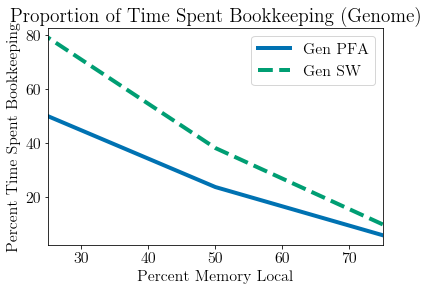

In [17]:
ax = (gen_bk_prop * 100).plot(
    kind="line",
    title="Proportion of Time Spent Bookkeeping (Genome)",
    style=["-", "--"],
    linewidth=4)
#qsort_bk_prop.plot(kind="line", title="Proportion of Time Spent Bookkeeping (Genome)", ax=ax)
ax.set_ylabel('Percent Time Spent Bookkeeping')
ax.set_xlabel('Percent Memory Local')
plt.savefig('figs/bk_prop.png', dpi=300, bbox_inches='tight')
plt.show()

          Gen PFA    Gen SW  Qsort PFA  Qsort SW
MemSize                                         
75.0     0.058933  0.098956   0.128899  0.239965
50.0     0.237175  0.381480   0.171244  0.323587
25.0     0.499261  0.790000   0.226426  0.413172


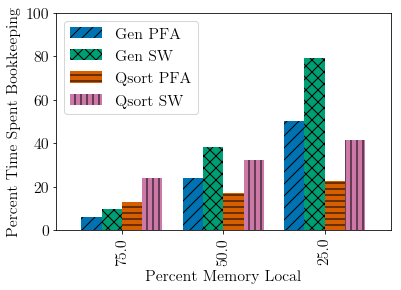

In [18]:
tmp = pd.concat([gen_bk_prop, qsort_bk_prop], axis=1)
print(tmp)
ax = (tmp * 100).plot(
    kind="bar",
    width=0.8,
    legend=False,
    ylim=(0, 100))

hatches = ['//', '//', '//', 2*'x', 2*'x', 2*'x', '--', '--', '--','||','||','||']
for i,bar in enumerate(ax.patches):
    bar.set_hatch(hatches[i])
    
ax.set_ylabel('Percent Time Spent Bookkeeping')
ax.set_xlabel('Percent Memory Local')
plt.legend()
plt.savefig('figs/bk_prop_all.png', dpi=300, bbox_inches='tight')
plt.show()

## End to End Performance


Slowdown relative to PFA
              gen     qsort
MemSize                    
75.0     1.381952  1.286133
50.0     1.403802  1.335836
25.0     1.192033  1.376575


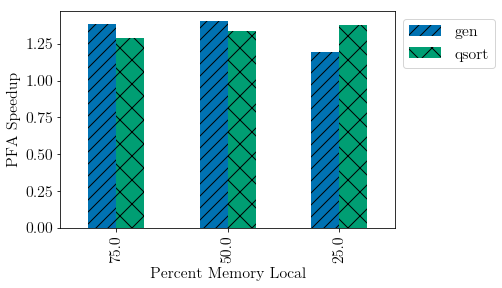

In [19]:
# Ratio of PFA runtime vs SW
print("\nSlowdown relative to PFA")
relative_speed = pd.concat([(gen_sw_res['RunTime'] / gen_pfa_res['RunTime']).rename("gen"),
                            (qsort_sw_res['RunTime'] / qsort_pfa_res['RunTime']).rename("qsort")], axis=1)
print(relative_speed)
ax = relative_speed.plot(
    kind='bar')

hatches = ['//', '//', '//', 'x', 'x', 'x']
for i,bar in enumerate(ax.patches):
    bar.set_hatch(hatches[i])
    
ax.legend(bbox_to_anchor=(1, 1), loc=2)
plt.ylabel('PFA Speedup')
plt.xlabel('Percent Memory Local')
plt.savefig('figs/total_speedup.png', dpi=300, bbox_inches='tight')
plt.show()

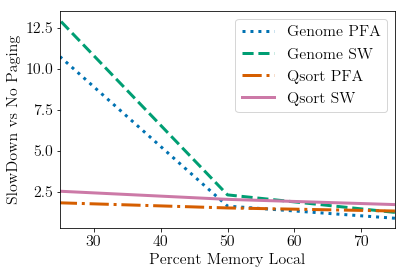

In [20]:
total_slowdown = pd.concat([gen_pfa_res['Slowdown'].rename("Genome PFA"),
                            gen_sw_res['Slowdown'].rename("Genome SW"),
                            qsort_pfa_res['Slowdown'].rename("Qsort PFA"),
                            qsort_sw_res['Slowdown'].rename("Qsort SW")],
                          axis=1)

ax = total_slowdown.plot(
    kind='line',
    style=[':', '--', '-.', '-'],
    linewidth=3)
plt.ylabel('SlowDown vs No Paging')
plt.xlabel('Percent Memory Local')
plt.show()

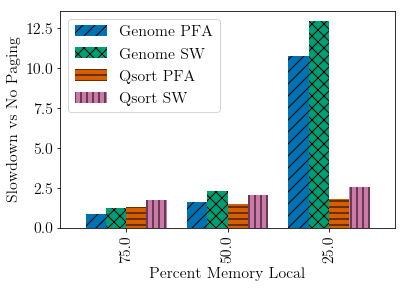

In [21]:
ax = total_slowdown.plot(
    kind='bar',
    legend=False,
    width=0.8)
ax.set_ylabel('Slowdown vs No Paging')
ax.set_xlabel('Percent Memory Local')

hatches = ['//', '//', '//', 2*'x', 2*'x', 2*'x', '--', '--', '--','||','||','||']
for i,bar in enumerate(ax.patches):
    bar.set_hatch(hatches[i])
    
ax.legend()    

plt.savefig('figs/perf_nokswapd.png', dpi=300, bbox_inches='tight')
plt.show()